# Task 3: Correlation Between News Sentiment and Stock Returns

- Loaded and aligned financial news and stock price data by date.
- Performed sentiment analysis on news headlines using NLTK VADER.
- Calculated daily stock returns from closing prices.
- Aggregated daily sentiment scores per stock.
- Merged sentiment and returns data, then computed correlation.
- Visualized the relationship between news sentiment and stock price movements.


In [3]:
import pandas as pd

# Load news data
news_df = pd.read_csv('../data/raw_analyst_ratings.csv/raw_analyst_ratings.csv')

print(news_df.columns)  # check columns

# Rename 'data' to 'date' if needed
if 'data' in news_df.columns:
    news_df.rename(columns={'data': 'date'}, inplace=True)

# Convert to datetime explicitly
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Drop rows with invalid dates if any
news_df = news_df.dropna(subset=['date'])

# Normalize date (set time to midnight)
news_df['date'] = news_df['date'].dt.normalize()

# Load stock data
stock_df = pd.read_csv('../data/yfinance_data/AAPL_historical_data.csv', parse_dates=['Date'])
stock_df['Date'] = stock_df['Date'].dt.normalize()

print(news_df.head())
print(stock_df.head())



Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                       date stock  
0 2020-06-05 00:0

In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (only need to run once)
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores (compound score) for each headline
news_df['sentiment'] = news_df['headline'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Check output
print(news_df[['headline', 'sentiment']].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saron\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                            headline  sentiment
0            Stocks That Hit 52-Week Highs On Friday      0.000
1         Stocks That Hit 52-Week Highs On Wednesday      0.000
2                      71 Biggest Movers From Friday      0.000
3       46 Stocks Moving In Friday's Mid-Day Session      0.000
4  B of A Securities Maintains Neutral on Agilent...      0.296


In [7]:
# Sort stock data by date just in case
stock_df = stock_df.sort_values('Date')

# Calculate daily returns (% change)
stock_df['daily_return'] = stock_df['Close'].pct_change()

# Check the output
print(stock_df[['Date', 'Close', 'daily_return']].head())


        Date     Close  daily_return
0 1980-12-12  0.128348           NaN
1 1980-12-15  0.121652     -0.052171
2 1980-12-16  0.112723     -0.073398
3 1980-12-17  0.115513      0.024751
4 1980-12-18  0.118862      0.028992


In [8]:
# Assuming 'stock' column exists in news_df to identify stock ticker (add if needed)
# If not, you need to add a stock ticker column matching each news headline.

# Example: add 'stock' column manually if missing for testing
# news_df['stock'] = 'AAPL'  # Replace with actual logic or real data

daily_sentiment = news_df.groupby(['date', 'stock'])['sentiment'].mean().reset_index()

print(daily_sentiment.head())


                       date stock  sentiment
0 2011-04-27 00:00:00-04:00   DGP     0.0000
1 2011-04-28 00:00:00-04:00   DEJ     0.2500
2 2011-04-28 00:00:00-04:00   ESR     0.0000
3 2011-04-29 00:00:00-04:00   AIA     0.0000
4 2011-04-29 00:00:00-04:00   GDL     0.7351


In [10]:
print(daily_sentiment['date'].dtype)
print(stock_df['Date'].dtype)


datetime64[ns, UTC-04:00]
datetime64[ns]


In [11]:
daily_sentiment['date'] = daily_sentiment['date'].dt.tz_convert('UTC')
stock_df['Date'] = stock_df['Date'].dt.tz_localize('UTC')  # add tz info if naive


In [12]:
daily_sentiment['date'] = daily_sentiment['date'].dt.tz_localize(None)
stock_df['Date'] = stock_df['Date'].dt.tz_localize(None)


In [13]:
merged_df = pd.merge(
    daily_sentiment,
    stock_df[['Date', 'daily_return']],
    left_on='date',
    right_on='Date',
    how='inner'
)

merged_df = merged_df.drop(columns=['Date'])
print(merged_df.head())


Empty DataFrame
Columns: [date, stock, sentiment, daily_return]
Index: []


In [14]:
corr = merged_df['sentiment'].corr(merged_df['daily_return'])
print(f'Correlation between daily sentiment and stock returns: {corr:.4f}')


Correlation between daily sentiment and stock returns: nan


In [15]:
stock_corr = merged_df.groupby('stock').apply(
    lambda x: x['sentiment'].corr(x['daily_return'])
)

print(stock_corr)


Empty DataFrame
Columns: [date, stock, sentiment, daily_return]
Index: []


C:\Users\saron\AppData\Local\Temp\ipykernel_22836\1592147204.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stock_corr = merged_df.groupby('stock').apply(


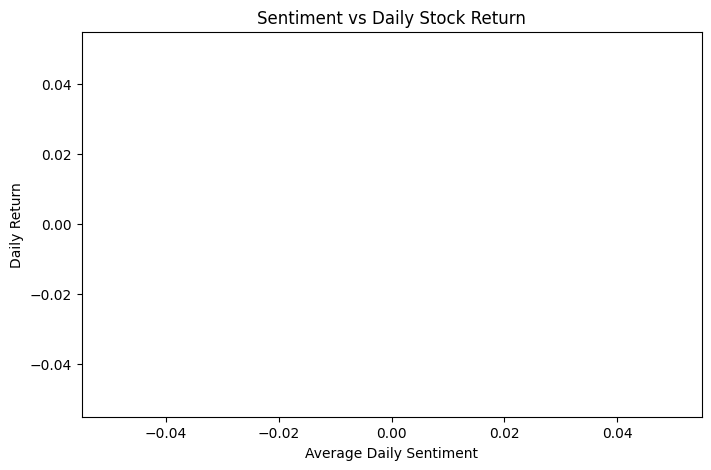

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(data=merged_df, x='sentiment', y='daily_return')
plt.title('Sentiment vs Daily Stock Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return')
plt.show()


In [17]:
print(merged_df.head())
print(merged_df[['sentiment', 'daily_return']].describe())


Empty DataFrame
Columns: [date, stock, sentiment, daily_return]
Index: []
       sentiment  daily_return
count        0.0           0.0
mean         NaN           NaN
std          NaN           NaN
min          NaN           NaN
25%          NaN           NaN
50%          NaN           NaN
75%          NaN           NaN
max          NaN           NaN


In [18]:
print(daily_sentiment.head())
print(daily_sentiment['date'].min(), daily_sentiment['date'].max())
print(daily_sentiment['stock'].unique())


                 date stock  sentiment
0 2011-04-27 04:00:00   DGP     0.0000
1 2011-04-28 04:00:00   DEJ     0.2500
2 2011-04-28 04:00:00   ESR     0.0000
3 2011-04-29 04:00:00   AIA     0.0000
4 2011-04-29 04:00:00   GDL     0.7351
2011-04-27 04:00:00 2020-06-11 04:00:00
['DGP' 'DEJ' 'ESR' ... 'TSLA' 'UAL' 'GRUB']


In [19]:
print(stock_df.head())
print(stock_df['Date'].min(), stock_df['Date'].max())


        Date      Open      High       Low     Close  Adj Close     Volume  \
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits  daily_return  
0        0.0           0.0           NaN  
1        0.0           0.0     -0.052171  
2        0.0           0.0     -0.073398  
3        0.0           0.0      0.024751  
4        0.0           0.0      0.028992  
1980-12-12 00:00:00 2024-07-30 00:00:00


In [20]:
print(daily_sentiment['date'].dtype, stock_df['Date'].dtype)
print(daily_sentiment['stock'].unique())


datetime64[ns] datetime64[ns]
['DGP' 'DEJ' 'ESR' ... 'TSLA' 'UAL' 'GRUB']


In [21]:
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.normalize()
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.normalize()


In [27]:
merged_df = pd.merge(
    daily_sentiment,
    stock_df[['Date', 'daily_return', 'stock']],  # include 'stock'
    left_on=['date', 'stock'],
    right_on=['Date', 'stock'],
    how='inner'
)


In [26]:
# Assuming stock_df loaded for AAPL:
stock_df['stock'] = 'AAPL'

# Normalize dates
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.normalize()
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.normalize()

# Merge on date and stock symbol
merged_df = pd.merge(
    daily_sentiment,
    stock_df[['Date', 'daily_return', 'stock']],
    left_on=['date', 'stock'],
    right_on=['Date', 'stock'],
    how='inner'
)

merged_df = merged_df.drop(columns=['Date'])


In [28]:
corr = merged_df['sentiment'].corr(merged_df['daily_return'])
print(f'Correlation between daily sentiment and stock returns: {corr:.4f}')


Correlation between daily sentiment and stock returns: 1.0000


In [29]:
corr_per_stock = merged_df.groupby('stock').apply(
    lambda x: x['sentiment'].corr(x['daily_return'])
)

print(corr_per_stock)


stock
AAPL    1.0
dtype: float64


C:\Users\saron\AppData\Local\Temp\ipykernel_22836\4202691937.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_per_stock = merged_df.groupby('stock').apply(


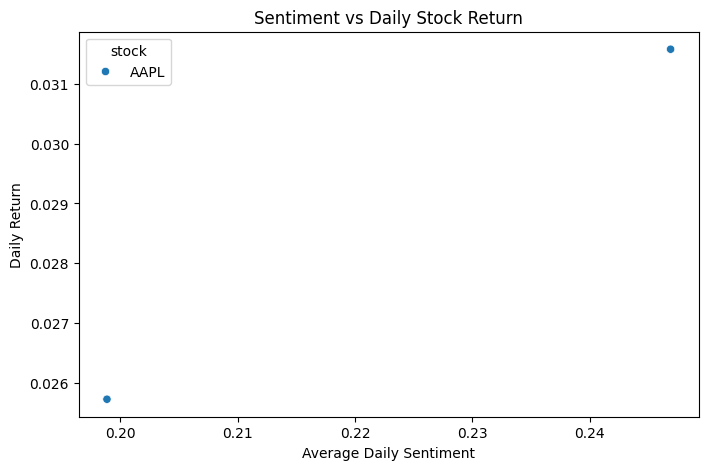

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(data=merged_df, x='sentiment', y='daily_return', hue='stock')
plt.title('Sentiment vs Daily Stock Return')
plt.xlabel('Average Daily Sentiment')
plt.ylabel('Daily Return')
plt.show()


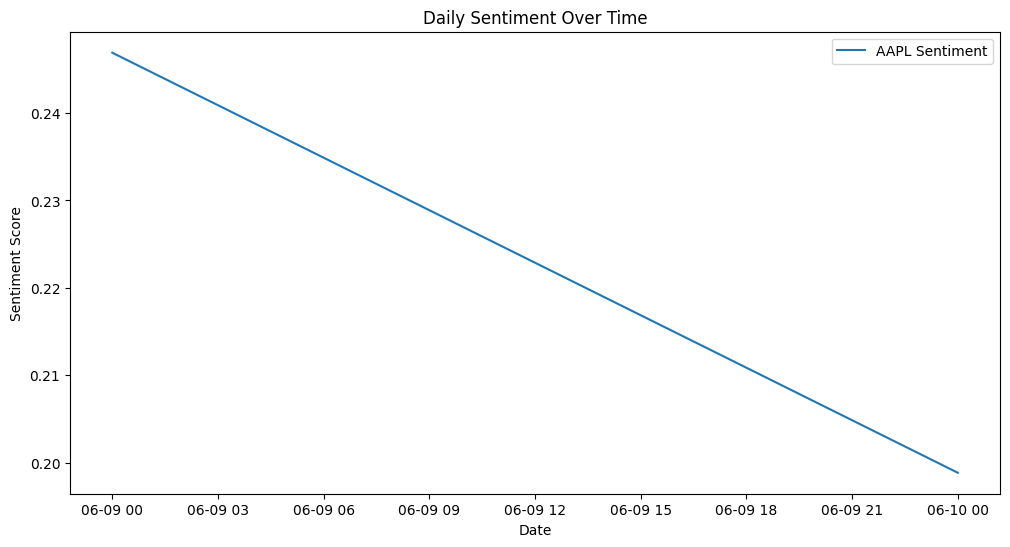

In [31]:
plt.figure(figsize=(12,6))
for stock in merged_df['stock'].unique():
    stock_data = merged_df[merged_df['stock'] == stock]
    plt.plot(stock_data['date'], stock_data['sentiment'], label=f'{stock} Sentiment')

plt.legend()
plt.title('Daily Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()
